In [4]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ml'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
vone_dir = '/user_data/vayzenbe/GitHub_Repos/vonenet'
cornet_dir = '/user_data/vayzenbe/GitHub_Repos/CORnet'

sys.path.insert(1, vone_dir)
sys.path.insert(1, cornet_dir)
import vonenet
import cornet

import torch

import torch.nn as nn
import torchvision
import load_stim


In [11]:
stim_dir = f'{curr_dir}/stim'

model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module
layer_call = "getattr(getattr(model,'decoder'),'avgpool')"

transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
            ])

In [12]:
def extract_acts(model, image_dir, transform, layer_call):
    print('extracting features...')
    

    #set up hook to specified layer
    def _store_feats(layer, inp, output):
        """An ugly but effective way of accessing intermediate model features
        """
        #avgpool = nn.AdaptiveAvgPool2d(output_size=(1,768))
        #output = avgpool(output)
        

        output = output.cpu().numpy()
        
        _model_feats.append(np.reshape(output, (len(output), -1)))

    try:
        m = model.module
    except:
        m = model
    #model_layer = getattr(getattr(m, layer), sublayer)
    model_layer = eval(layer_call)
    model_layer.register_forward_hook(_store_feats)



    #Iterate through each image and extract activations

    imNum = 0
    n=0

    

    
    test_dataset = load_stim.load_stim(image_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 4, pin_memory=True)
    


    with torch.no_grad():
        
        for data, _ in testloader:
            # move tensors to GPU if CUDA is available
            
            #data= data.cuda()
            
            _model_feats = []
            model(data)
            #output = model(data)
            
            out = np.vstack(_model_feats)
            

            if n == 0:
                acts = out
                #label_list = label
            else:
                acts= np.append(acts, out,axis = 0)
                #label_list = np.append(label_list, label)
                
            
            n = n + 1

    return acts

In [13]:
acts = extract_acts(model, stim_dir, transform, layer_call)

extracting features...


In [16]:
#create correlation matrix for activations
corr = np.corrcoef(acts)

In [17]:
corr.shape

(8, 8)

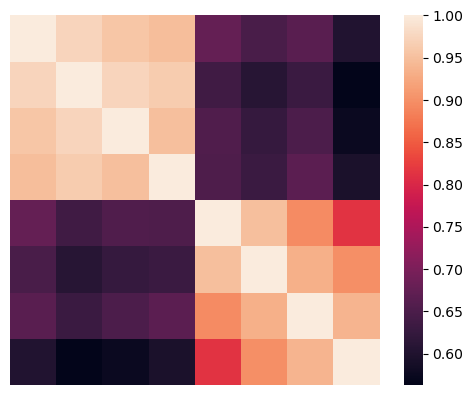

In [23]:
sns.heatmap(corr, cbar=True)

#remove axis labels
plt.xticks([])
plt.yticks([])

#remove tick lines
plt.tick_params(left=False, bottom=False)

#make square
plt.gca().set_aspect('equal', adjustable='box')


#save figure
plt.savefig('corr_matrix.png', dpi=300, bbox_inches='tight')


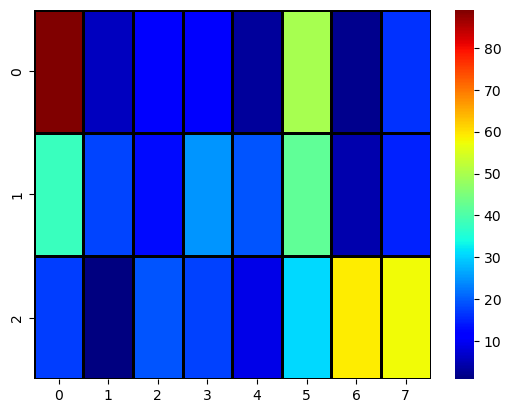

In [20]:


#create heatmap with seaborn
#add linse between cells
ax = sns.heatmap(acts, linewidths=1, cmap='jet', linecolor='black')
